In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import string
from nltk.stem.porter import PorterStemmer # for text lemmantation
from keras.layers import TextVectorization, SimpleRNN, Input, Embedding, Dense, Bidirectional, LSTM, Dropout, GRU, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api # for transfer learning

2023-11-10 08:03:49.996517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 08:03:49.996576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 08:03:49.996610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 08:03:50.004600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data loading

In [6]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[:50%]'], as_supervised=True)

2023-11-10 08:31:05.597260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 08:31:05.603130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 08:31:05.603333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
for text, label in train_ds.take(1):
    tf.print(text)
    tf.print(label)

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0


2023-11-10 08:31:06.067358: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Data preprocessing

In [9]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data) # convert to lower case

    no_tag = tf.strings.regex_replace(lowercase, "<[^>]+>", "") # remove html tags. check regex for syntex
    output = tf.strings.regex_replace(no_tag, "[%s]"%re.escape(string.punctuation), "") # remove special characters

    return output

In [10]:
PorterStemmer().stem('tensed') # lemmantatiom

'tens'

In [11]:
input = '<input id="shortcuts-toggle" type="checkbox" preference="feeds.topsites" aria-labelledby="custom-shortcuts-title" aria-describedby="custom-shortcuts-subtitle" eventsource="TOP_SITES" checked=""><span class="slider" role="presentation"></span><h1>hello:{hello|}</h1>'
tf.print(standardization(input))

hellohello


# standardization and tokenization

In [12]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
EMBADDING_DIM = 300
BATCH_SIZE=64

In [13]:
# max_tokens get first 10,000 words
# int mode mens each word in vocabulary is given an index. then each word in string is replaced by vocubulary index. the length of the string is 250
# in multi one hot encode model each word is replaced by a vector of vocabulary size. 
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [14]:
# lengths = []
# words = []

# for review, label in train_dataset.take(25):
#     for word in tf.strings.split(review, sep=' '):
#         if word in words:
#             pass
#         else:
#             words.append(word)
#     lengths.append(len(tf.strings.split(review, sep=' ')))

In [15]:
# print(len(words))
# print(np.mean(lengths))## this is done to get a generalize idea about the sequence length

In [16]:
train_dataset = train_ds.map(lambda x, y:x) ## input x, y and outputs x only the review not label
vectorize_layer.adapt(train_dataset)

In [17]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'more',
 'very',
 'when',
 'she',
 'even',
 'up',
 'no',
 'would',
 'my',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'been',
 'get',
 'well',
 'will',
 'into',
 'because',
 'people',
 'other',
 'also',
 'do',
 'bad',
 'great',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'movies',
 'then',
 'films',
 'make',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'plot',
 'where',
 'best',
 '

In [18]:
def vectorizer(review, label):
    return vectorize_layer(review), label

In [19]:
train_dataset = train_ds.map(vectorizer)
val_dataset = val_ds.map(vectorizer)
test_dataset = test_ds.map(vectorizer)

In [20]:
for review, label in train_dataset.take(1):
    print(review)
    print(label)# in vocabulary The is represented by 10th index. so first The in sentence replaced by 10

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [21]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [22]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
for review, label in train_ds.take(1):
    print(review)
    print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [24]:
for review, label in train_dataset.take(1):
    print(review.shape)
    print(label)

(64, 250)
tf.Tensor(
[0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1], shape=(64,), dtype=int64)


In [25]:
for review, label in val_dataset.take(1):
    print(review.shape)
    print(label.shape)

(64, 250)
(64,)


2023-11-10 08:31:51.083301: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
input = np.random.random([32, 100, 8]).astype(np.float32) # here 32 is batch size, 100 is sample length and 8 is vocabulary size
simple_rnn = SimpleRNN(units=25, return_state=True) # return seqence will give output of all layers. no of layers = no of sequence in simple rnn
# return state parameter returns both output vector and activation vector in last layer
a, y= simple_rnn(input)
print(a.shape, y.shape)

(32, 25) (32, 25)


# Simple RNN

In [67]:
EMBADDING_DIM = 64

model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBADDING_DIM),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 64)           640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
checkpoint_filepath = './sentiment_rnn.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
143/782 [====>.........................] - ETA: 1:55 - loss: 0.6971 - accuracy: 0.4952

KeyboardInterrupt: 

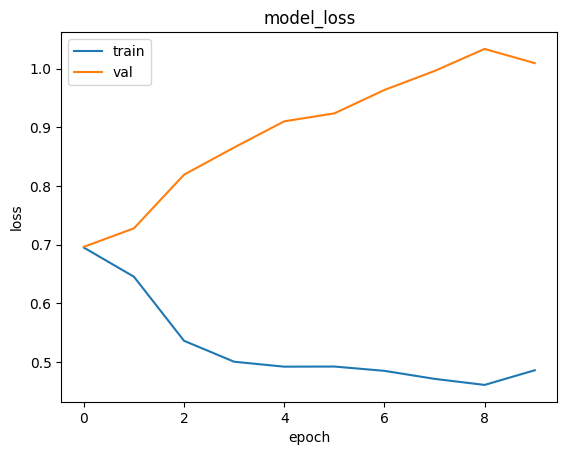

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

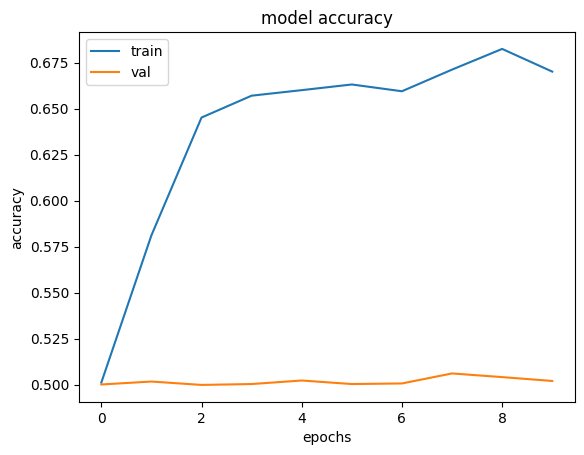

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [71]:
model.load_weights('./sentiment_rnn.keras')
model.evaluate(test_dataset)

391/391 [==============================] - 8s 19ms/step - loss: 0.9960 - accuracy: 0.5061


[0.9960004091262817, 0.5060799717903137]

# LSTM

In [29]:
EMBADDING_DIM = 64
lstm_model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBADDING_DIM),

    Bidirectional(LSTM(EMBADDING_DIM, return_sequences=True)),
    Bidirectional(LSTM(int(EMBADDING_DIM/2))),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_5 (Bidirecti  (None, 250, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [32]:
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_checkpoint_callback = ModelCheckpoint(
    './sentiment_lstm.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

In [33]:
history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10


2023-11-10 00:06:24.354696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-10 00:06:25.577478: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab4c3ddc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 00:06:25.577500: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-11-10 00:06:25.584443: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 00:06:25.672016: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 75s 88ms/step - loss: 0.5290 - accuracy: 0.7220 - val_loss: 0.3945 - val_accuracy: 0.8336
Epoch 2/10
782/782 [==============================] - 27s 35ms/step - loss: 0.3067 - accuracy: 0.8810 - val_loss: 0.4269 - val_accuracy: 0.8394
Epoch 3/10
782/782 [==============================] - 28s 36ms/step - loss: 0.2374 - accuracy: 0.9156 - val_loss: 0.4077 - val_accuracy: 0.8462
Epoch 4/10
782/782 [==============================] - 29s 37ms/step - loss: 0.1912 - accuracy: 0.9334 - val_loss: 0.4607 - val_accuracy: 0.8445
Epoch 5/10
782/782 [==============================] - 29s 36ms/step - loss: 0.1491 - accuracy: 0.9500 - val_loss: 0.5233 - val_accuracy: 0.8278
Epoch 6/10
782/782 [==============================] - 26s 34ms/step - loss: 0.1221 - accuracy: 0.9596 - val_loss: 0.5336 - val_accuracy: 0.8367
Epoch 7/10
782/782 [==============================] - 27s 34ms/step - loss: 0.1140 - accuracy: 0.9623 - val_loss: 0.5584 - val_accuracy: 0.8353
Epo

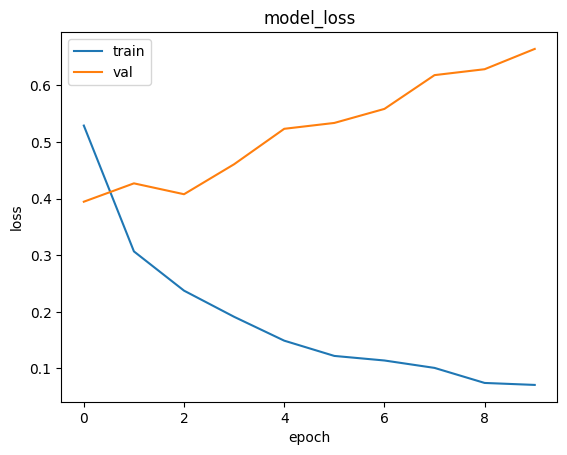

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

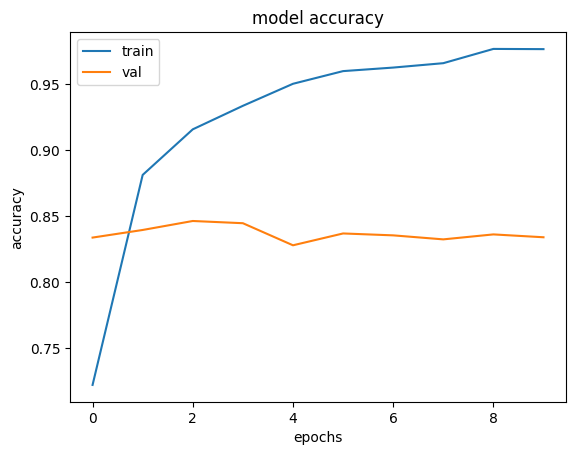

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [72]:
lstm_model.evaluate(test_dataset)

391/391 [==============================] - 5s 12ms/step - loss: 0.6644 - accuracy: 0.8338


[0.6643660068511963, 0.833840012550354]

# GRU

In [75]:
EMBADDING_DIM = 64
gru_model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBADDING_DIM),

    Bidirectional(GRU(EMBADDING_DIM, return_sequences=True)),
    Bidirectional(GRU(int(EMBADDING_DIM/2))),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_9 (Bidirecti  (None, 250, 128)          49920     
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 64)                31104     
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                

In [76]:
gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_checkpoint_callback = ModelCheckpoint(
    './sentiment_gru.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

In [77]:
history = gru_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
782/782 [==============================] - 56s 65ms/step - loss: 0.5070 - accuracy: 0.7520 - val_loss: 0.5686 - val_accuracy: 0.7522
Epoch 2/10
782/782 [==============================] - 25s 32ms/step - loss: 0.3103 - accuracy: 0.8768 - val_loss: 0.3355 - val_accuracy: 0.8597
Epoch 3/10
782/782 [==============================] - 26s 33ms/step - loss: 0.2196 - accuracy: 0.9200 - val_loss: 0.3697 - val_accuracy: 0.8543
Epoch 4/10
782/782 [==============================] - 26s 33ms/step - loss: 0.1729 - accuracy: 0.9395 - val_loss: 0.4241 - val_accuracy: 0.8443
Epoch 5/10
782/782 [==============================] - 26s 34ms/step - loss: 0.1308 - accuracy: 0.9550 - val_loss: 0.4905 - val_accuracy: 0.8508
Epoch 6/10
782/782 [==============================] - 27s 34ms/step - loss: 0.0995 - accuracy: 0.9656 - val_loss: 0.5345 - val_accuracy: 0.8531
Epoch 7/10
782/782 [==============================] - 27s 34ms/step - loss: 0.0760 - accuracy: 0.9749 - val_loss: 0.6376 - val_accuracy:

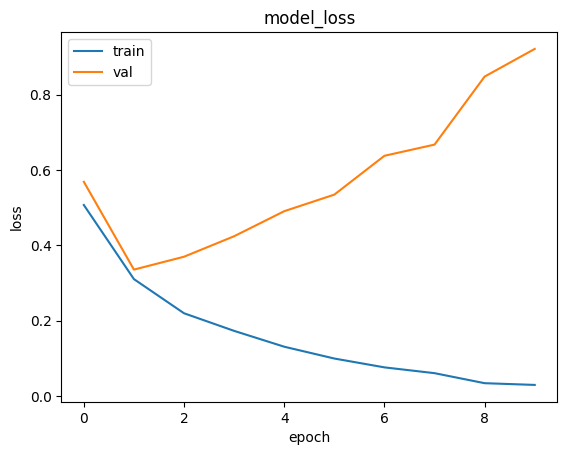

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

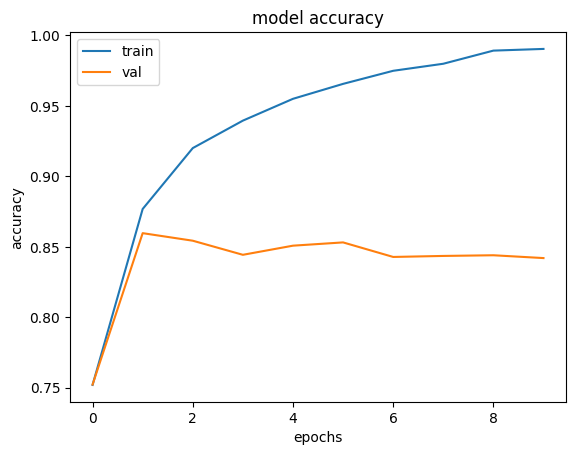

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## evaluate

In [80]:
gru_model.evaluate(test_dataset)

391/391 [==============================] - 5s 12ms/step - loss: 0.9213 - accuracy: 0.8420


[0.9212870597839355, 0.8420000076293945]

# Conv1D

In [37]:
EMBADDING_DIM = 64
conv_model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH)),
    Embedding(VOCAB_SIZE, EMBADDING_DIM), # as metrics size = 10,000*64 then 64,000 parameters

    Conv1D(32, 3, activation='relu'),
    Flatten(),

    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

conv_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           6176      
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense (Dense)               (None, 32)                253984    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 900193 (3.43 MB)
Trainable params: 900193 

In [38]:
conv_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_checkpoint_callback = ModelCheckpoint(
    './sentiment_conv.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

In [85]:
history = conv_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
782/782 [==============================] - 32s 39ms/step - loss: 0.4434 - accuracy: 0.7762 - val_loss: 0.3195 - val_accuracy: 0.8647
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2433 - accuracy: 0.9104 - val_loss: 0.3328 - val_accuracy: 0.8673
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.1633 - accuracy: 0.9418 - val_loss: 0.4471 - val_accuracy: 0.8564
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.1052 - accuracy: 0.9642 - val_loss: 0.6076 - val_accuracy: 0.8481
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0687 - accuracy: 0.9770 - val_loss: 0.7307 - val_accuracy: 0.8492
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0430 - accuracy: 0.9864 - val_loss: 0.7546 - val_accuracy: 0.8495
Epoch 7/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.9074 - val_accuracy: 0.8491
Epoc

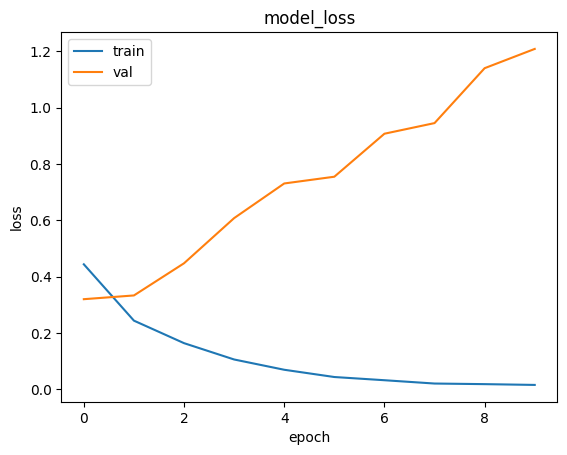

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

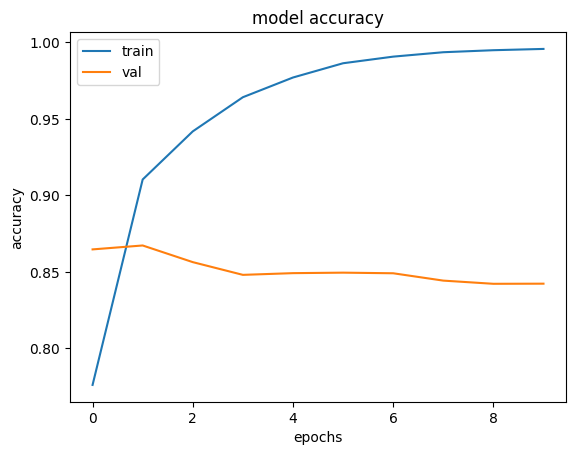

In [87]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:
conv_model.evaluate(test_dataset)

391/391 [==============================] - 2s 6ms/step - loss: 1.2087 - accuracy: 0.8423


[1.2087466716766357, 0.8423200249671936]

# Transfer Learning

In [4]:
word2vec = api.load('glove-wiki-gigaword-300') # can't download

KeyboardInterrupt: 

# Inference Ready Model

In [51]:
inputs = Input(shape=(1,), dtype='string')
vectorized_input = vectorize_layer(inputs)
outputs = conv_model(vectorized_input)
inference_ready_model = tf.keras.Model(inputs, outputs)
inference_ready_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 250)               0         
 ctorization)                                                    
                                                                 
 sequential (Sequential)     (None, 1)                 900193    
                                                                 
Total params: 900193 (3.43 MB)
Trainable params: 900193 (3.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Testing

## conv_model

In [39]:
conv_model.load_weights('./sentiment_conv.keras')

In [46]:
test_data = tf.data.Dataset.from_tensor_slices([["Growing up in the 80's 90's during the time of top anime stories and always getting into arguments with my friends and my son that those were the golden anime era and now I have to admit. This is if not the best story telling I witness in all my years. This show raise the bars with each episode, with unpredictable twist and turns you won't see coming. After completing season 4 mid season finally I must say I'm happy to be alive witnessing a master peace in the making. Can't wait for the finally"],
                                                ["Khan's death is a tragedy, but at least it led me to this absolute knock-out. A faithfully complex modern rendering of Hamlet, exploring the terrifying psychology of vengeance, guilt & forgiveness. However, that description doesn't do justice to how urgent the film is. Kapoor, who's like an Indian Tom Hardy, gives a lead performance for the ages, commanding every moment he's on screen, a screen filled with strikingly crisp & harrowing visuals."],
                                                ["Adipurush, if one remembers, was supposed to be an modern adaptation of Ramayan and hence the makers chose to have a free run with the creative liberties in this film and it all went wrong .Adipurush itself starts from the middle of Ramayana where lord Ram was sent to the jungles for 14 years exile . Hence the film doesn't have any build up to any character.First, the characters itself have no introduction whatsoever. Makers assume since we know Ramayana, so no need to introduce anyone properly. Lord Ram is just introduced through some pictures in the opening credit while laxman and Sita ma have even further lower introduction. Honestly saying if one didn't tell you that Sunny Singh is laxman, you probably won't know. Jatayu pops up randomly and gets to poorest adieu . It's almost as if Lord Ram doesn't even know who Jatayu is. Bali , the brother of Sugreev, has absolutely no introduction.Next, the setting. If it's a modern adaptation of Ramayana, then why is the Lord Ram side shown to be taken straight from Ramayana but Lanka and it's people especially Raavan are shown as people of some Azguard (Thor) ? Clearly there is inconsistency . If you remember the original Ramayana, both Ram and Raavan side had almost similar kind of dresses with kings wearing king like dresses etc. Here, both sides wear dresses belonging to opposite poles.Next, the execution. It's horrendous. Bali and Sugreev's fight is the worst looking one which gets over in no time without any introduction to Bali. As they fight, you can't even understand who is Bali and who is Sugreev. The part where Sita gets kidnapped by the Sadhu is not accurate. The Sadhu i believe never gave evil smiles . Jatayu's adieu is just ignored. In the earlier Ramayana, Jatayu has a heartfelt conversation with lord Ram in his arms before dying but here, Jatayu is just treated like a random bird. Last but not the least, everything on the lankan side is so poorly executed. Lord Hanuman burns Lanka with his tail but it barely burns, just random explosions here and there that's it.Next, I want to talk about Indrajith and Vibhishan. My god what kind of portrayal is this? Indrajit looks like a party animal from some Noida club and he possesses powers of Flash !! The level of creative liberties they took!! Vibhishan is so hard to believe he's vibhishan as he doesn't act like him only . They all got weird tattoos on their body especially indrajith . Itna bhi modern nahi karna tha !!VFX and dialogues. Let's not talk about it you already know how it is. The final war sequence also looks so cartoonish that it sucks the essence out of it.Let's talk about Raavan played by Saif. He does try very hard to make Raavan look menacing. His character is even given a terrifying bgm . However, the rest things of his looks so weird. His 10 heads rendered VFX looks hilarious at best. His hairstyle is again Noida Gurugram style. He feeds non veg to his dragon vehicle (why is non veg shown in this film at first place?). All these creative choices just don't fit Raavan. The makers have just played around with the Lanka side while fearfully avoiding any creative changes on Ram side .Songs are good as well as the BGM. That's the only reason I gave this film 2 stars.Prabhas as lord Ram should never have been there. He's just angry faced , barely smiles and has no expressions at all. His body is an entire VFX render throughout.Overall, i thought KBKJ was the worst film this year but Adipurush beats it by a mile solely because it has ruined an epic saga so close to all Hindus. Adipurush just shows a part of the entire Ramayana that too with little to no detailing with its running time being 3 hrs and back in 1992, the Yugo Sako version showed all details and the entire tale of Ram in under 2hrs 50 mins. It clearly shows the quality difference of the makers ."]
                                                ])

In [47]:
test_data

<_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.string, name=None)>

In [48]:
def vectorizer_test(review):
    return vectorize_layer(review)

test_dataset = test_data.map(vectorizer_test)

In [49]:
conv_model.predict(test_dataset)

3/3 [==============================] - 0s 2ms/step


array([[0.9572098 ],
       [0.9788983 ],
       [0.00121204]], dtype=float32)

## Inference Ready Model

In [52]:
test_data = [["Growing up in the 80's 90's during the time of top anime stories and always getting into arguments with my friends and my son that those were the golden anime era and now I have to admit. This is if not the best story telling I witness in all my years. This show raise the bars with each episode, with unpredictable twist and turns you won't see coming. After completing season 4 mid season finally I must say I'm happy to be alive witnessing a master peace in the making. Can't wait for the finally"],
                                                ["Khan's death is a tragedy, but at least it led me to this absolute knock-out. A faithfully complex modern rendering of Hamlet, exploring the terrifying psychology of vengeance, guilt & forgiveness. However, that description doesn't do justice to how urgent the film is. Kapoor, who's like an Indian Tom Hardy, gives a lead performance for the ages, commanding every moment he's on screen, a screen filled with strikingly crisp & harrowing visuals."],
                                                ["Adipurush, if one remembers, was supposed to be an modern adaptation of Ramayan and hence the makers chose to have a free run with the creative liberties in this film and it all went wrong .Adipurush itself starts from the middle of Ramayana where lord Ram was sent to the jungles for 14 years exile . Hence the film doesn't have any build up to any character.First, the characters itself have no introduction whatsoever. Makers assume since we know Ramayana, so no need to introduce anyone properly. Lord Ram is just introduced through some pictures in the opening credit while laxman and Sita ma have even further lower introduction. Honestly saying if one didn't tell you that Sunny Singh is laxman, you probably won't know. Jatayu pops up randomly and gets to poorest adieu . It's almost as if Lord Ram doesn't even know who Jatayu is. Bali , the brother of Sugreev, has absolutely no introduction.Next, the setting. If it's a modern adaptation of Ramayana, then why is the Lord Ram side shown to be taken straight from Ramayana but Lanka and it's people especially Raavan are shown as people of some Azguard (Thor) ? Clearly there is inconsistency . If you remember the original Ramayana, both Ram and Raavan side had almost similar kind of dresses with kings wearing king like dresses etc. Here, both sides wear dresses belonging to opposite poles.Next, the execution. It's horrendous. Bali and Sugreev's fight is the worst looking one which gets over in no time without any introduction to Bali. As they fight, you can't even understand who is Bali and who is Sugreev. The part where Sita gets kidnapped by the Sadhu is not accurate. The Sadhu i believe never gave evil smiles . Jatayu's adieu is just ignored. In the earlier Ramayana, Jatayu has a heartfelt conversation with lord Ram in his arms before dying but here, Jatayu is just treated like a random bird. Last but not the least, everything on the lankan side is so poorly executed. Lord Hanuman burns Lanka with his tail but it barely burns, just random explosions here and there that's it.Next, I want to talk about Indrajith and Vibhishan. My god what kind of portrayal is this? Indrajit looks like a party animal from some Noida club and he possesses powers of Flash !! The level of creative liberties they took!! Vibhishan is so hard to believe he's vibhishan as he doesn't act like him only . They all got weird tattoos on their body especially indrajith . Itna bhi modern nahi karna tha !!VFX and dialogues. Let's not talk about it you already know how it is. The final war sequence also looks so cartoonish that it sucks the essence out of it.Let's talk about Raavan played by Saif. He does try very hard to make Raavan look menacing. His character is even given a terrifying bgm . However, the rest things of his looks so weird. His 10 heads rendered VFX looks hilarious at best. His hairstyle is again Noida Gurugram style. He feeds non veg to his dragon vehicle (why is non veg shown in this film at first place?). All these creative choices just don't fit Raavan. The makers have just played around with the Lanka side while fearfully avoiding any creative changes on Ram side .Songs are good as well as the BGM. That's the only reason I gave this film 2 stars.Prabhas as lord Ram should never have been there. He's just angry faced , barely smiles and has no expressions at all. His body is an entire VFX render throughout.Overall, i thought KBKJ was the worst film this year but Adipurush beats it by a mile solely because it has ruined an epic saga so close to all Hindus. Adipurush just shows a part of the entire Ramayana that too with little to no detailing with its running time being 3 hrs and back in 1992, the Yugo Sako version showed all details and the entire tale of Ram in under 2hrs 50 mins. It clearly shows the quality difference of the makers ."]
                                                ]

In [53]:
inference_ready_model.predict(test_data)

1/1 [==============================] - 1s 944ms/step


2023-11-10 08:50:10.708856: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


array([[0.9572098 ],
       [0.9788983 ],
       [0.00121204]], dtype=float32)